In [400]:
dataset_dir = "/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/google_sets/good_cats/"

In [222]:
import os
filename = dataset_dir + "88.jpg" # os.listdir(dataset_dir)[0]
print(filename)

/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/google_sets/google_images_cats_pass_1/88.jpg


In [213]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /home/sash/.cache/torch/hub/pytorch_vision_v0.6.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [403]:
print(filename)

/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/google_sets/good_cats/Screen Shot 2020-04-25 at 4.10.26 PM.png


In [410]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = Image.new("RGB", input_image.size, (255, 255, 255))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print(input_image.mode)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

RGB


In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
output = output_predictions.byte().cpu().numpy()
import matplotlib.pyplot as plt
plt.imshow(r, cmap="gray")
kernel = output

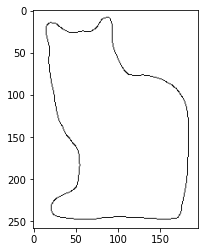

In [247]:
contour = auto_canny(output)
plt.imshow(~contour, cmap="gray")


## Mask out the image into the right size: 256

In [181]:
import numpy as np
new_list = output_predictions.byte().cpu().detach().numpy()
my_mean = np.mean(new_list)
print(my_mean)

0.0


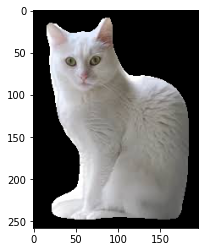

In [263]:
mask = torch.tensor(output > 7).unsqueeze(2).repeat(1, 1, 3).numpy()
plt.imshow(np.multiply(mask, input_image), cmap="gray")

0
8
(149, 339)


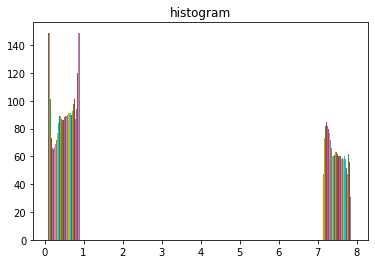

In [190]:
print(np.min(output))
print(np.max(output))
print(output.shape)
plt.hist(output,bins = [0,1,2,3,4,5,6,7,8]) 
plt.title("histogram") 
plt.show()

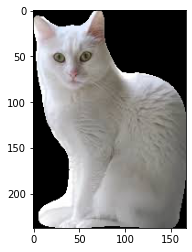

In [264]:
x_mask = mask.max(axis=(0, 2))
y_mask = mask.max(axis=(1, 2))
x_coords = np.where(x_mask)[0]
y_coords = np.where(y_mask)[0]
x1, y1 = x_coords.min(), y_coords.min()
x2, y2 = x_coords.max(), y_coords.max()

plt.imshow(np.multiply(mask, input_image)[y1:y2, x1:x2, :], cmap="gray")

In [82]:
print(f"width: {x2-x1}")
print(f"height: {y2-y1}")

width: 167
height: 238


In [227]:
# the output of this is the content of interest stripped out
def rescale_to_size(masks, size, cx, cy, minx, miny, maxx, maxy):
    maxSize = max(maxx-minx, maxy-miny)
    scale = size / maxSize
    height, width = masks.shape[:2]
    resized = cv2.resize(masks, (int(width*scale), int(height*scale)), interpolation = cv2.INTER_AREA)
    print(f"rescale: scale: {scale}, original cx: {cx}, original cy: {cy}")
    ncx = int(cx*scale)
    ncy = int(cy*scale)
    nminx = int(minx*scale)
    nmaxx = int(maxx*scale)
    nminy = int(miny*scale)
    nmaxy = int(maxy*scale)

    nmaxSize = max(nmaxx-nminx, nmaxy-nminy)
    print(f"rescale: nmaxSize: {nmaxSize}")
    assert nmaxSize == size or nmaxSize == size - 1
    return resized[nminy:nmaxy, nminx:nmaxx, :], int(nmaxx-nminx)//2, int(nmaxy-nminy)//2, 0, 0, nmaxx-nminx, nmaxy-nminy


In [83]:
def padding_to_size(masks, size, cx, cy, minx, miny, maxx, maxy):
    print(f"padding: cx-minx: {cx-minx}")
    img_height, img_width = masks.shape[:2]
    smallest = min(cx, cy, img_width-cx, img_height-cy)
    padding = size/2 - smallest

    if padding <= 0:
        print("padding: no padding necessary.")
        minx = int(cx-size/2)
        miny = int(cy-size/2)
        print(minx, miny, minx+size, miny+size)
        return masks, minx, miny, minx+size, miny+size

    padding = int(padding)
    print(f"padding: amount {padding}")
    print(f"padding: original masks shape: {masks.shape}")
    print(f"padding: cx, cy: {(cx, cy)}")
    padded_masks = np.pad(
        masks,
        ((padding, padding), (padding, padding), (0, 0)), 
        constant_values=((255, 255), (255, 255), (0, 0))
    )
#       TODO: this following code doesn't work, figure out why
#         padded_masks = np.zeros((2*padding+img_width, 2*padding+img_height))
#         padded_masks[padding:-padding, padding:-padding, :] = masks
    print(f"padding: padded shape: {padded_masks.shape}")
    minx = int(cx + padding - size/2)
    maxx = minx + size

    miny = int(cy + padding - size/2)
    maxy = miny + size
    return padded_masks, minx, miny, maxx, maxy

(258, 196, 3)
255
0


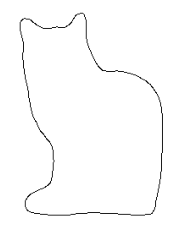

In [269]:
# plt.axis('off')
# plt.imshow(np.ma.masked_where(mask > 0, 1))
# plt.show()

mask_with_image = (mask * input_image + 255 * (1 - mask) * np.ones_like(input_image)).astype('uint8')
rearranged_mask = (mask * 255).astype(np.uint8)
print(rearranged_mask.shape)
print(np.max(rearranged_mask))
print(np.min(rearranged_mask))

mask_canny = auto_canny(rearranged_mask)
plt.axis('off')
plt.imshow(~mask_canny, cmap="gray")
plt.show()

rescale: scale: 1.0756302521008403, original cx: 99, original cy: 128
rescale: nmaxSize: 256
rescaled shape: (256, 179, 3), cx: 89, cy: 128
padding: cx-minx: 89
padding: amount 39
padding: original masks shape: (256, 179, 3)
padding: cx, cy: (89, 128)
padding: padded shape: (334, 257, 3)
padded masks shape: (334, 257, 3)


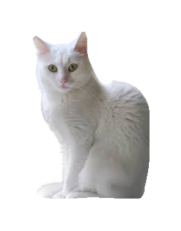

In [229]:
masked_img = mask
minx = x1
maxx = x2
miny = y1
maxy = y2
cx = int((x1+x2)/2)
cy = int((y1+y2)/2)
size = 256

masked_img, cx, cy, minx, miny, maxx, maxy = rescale_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy)
print(f"rescaled shape: {masked_img.shape}, cx: {cx}, cy: {cy}")
masked_img, minx, miny, maxx, maxy = padding_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy)
print(f"padded masks shape: {masked_img.shape}")

plt.axis('off')
plt.imshow(masked_img)
plt.show()

In [136]:
def crop_to_size(masks, minx, miny, maxx, maxy):
    print(f"before cropping masks shape: {masks.shape}")
    print(f"{miny, minx, maxy, maxx}")
    return masks[miny:maxy, minx:maxx, :]

before cropping masks shape: (334, 257, 3)
(39, 0, 295, 256)
cropped masks shape: (256, 256, 3)


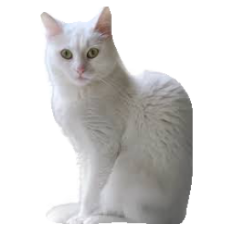

In [230]:
masked_img = crop_to_size(masked_img, minx, miny, maxx, maxy)
print(f"cropped masks shape: {masked_img.shape}")

plt.axis('off')
plt.imshow(masked_img)
plt.show()

In [158]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

In [241]:
import cv2
def collate_image_with_edge(img, kernel):
    print(f"kernel shape: {kernel.shape}")
    height, width = img.shape[:2]
    assert height == 256, width == 256
    image = cv2.dilate(img, kernel, iterations = 1)
    
    edges = cv2.Canny(image, 100, 200).reshape((width, height, 1))
    edges = np.repeat(edges, 3, axis=2)
    
    auto_edges = auto_canny(image).reshape((width, height, 1))
    auto_edges = np.repeat(auto_edges, 3, axis=2)
    
    print(f"edges.shape: {edges.shape}")
    print(f"img.shape: {img.shape}")
    collated_img = np.hstack([~edges, ~auto_edges, img, image])
    return collated_img

kernel shape: (258, 196)
edges.shape: (256, 256, 3)
img.shape: (256, 256, 3)


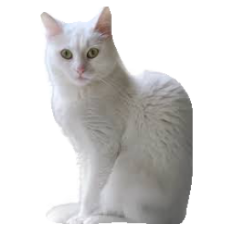

In [243]:
collated_img = collate_image_with_edge(masked_img, kernel.astype(np.uint8))
plt.axis('off')
plt.imshow(masked_img)
plt.show()

### Rerun

In [370]:
import cv2

# the output of this is the content of interest stripped out
def rescale_to_size(masks, size, cx, cy, minx, miny, maxx, maxy):
    maxSize = max(maxx-minx, maxy-miny)
    scale = size / maxSize
    height, width = masks.shape[:2]
    resized = cv2.resize(masks, (int(width*scale), int(height*scale)), interpolation = cv2.INTER_AREA)
    print(f"rescale: scale: {scale}, original cx: {cx}, original cy: {cy}")
    ncx = int(cx*scale)
    ncy = int(cy*scale)
    nminx = int(minx*scale)
    nmaxx = int(maxx*scale)
    nminy = int(miny*scale)
    nmaxy = int(maxy*scale)

    nmaxSize = max(nmaxx-nminx, nmaxy-nminy)
    print(f"rescale: nmaxSize: {nmaxSize}")
    assert nmaxSize == size or nmaxSize == size - 1
    return resized[nminy:nmaxy, nminx:nmaxx, :], int(nmaxx-nminx)//2, int(nmaxy-nminy)//2, 0, 0, nmaxx-nminx, nmaxy-nminy

def padding_to_size(masks, size, cx, cy, minx, miny, maxx, maxy):
    print(f"padding: cx-minx: {cx-minx}")
    img_height, img_width = masks.shape[:2]
    smallest = min(cx, cy, img_width-cx, img_height-cy)
    padding = size/2 - smallest

    if padding <= 0:
        print("padding: no padding necessary.")
        minx = int(cx-size/2)
        miny = int(cy-size/2)
        print(minx, miny, minx+size, miny+size)
        return masks, minx, miny, minx+size, miny+size

    padding = int(padding)
    print(f"padding: amount {padding}")
    print(f"padding: original masks shape: {masks.shape}")
    print(f"padding: cx, cy: {(cx, cy)}")
    padded_masks = np.pad(
        masks,
        ((padding, padding), (padding, padding), (0, 0)), 
        constant_values=((255, 255), (255, 255), (0, 0))
    )
#       TODO: this following code doesn't work, figure out why
#         padded_masks = np.zeros((2*padding+img_width, 2*padding+img_height))
#         padded_masks[padding:-padding, padding:-padding, :] = masks
    print(f"padding: padded shape: {padded_masks.shape}")
    minx = int(cx + padding - size/2)
    maxx = minx + size

    miny = int(cy + padding - size/2)
    maxy = miny + size
    return padded_masks, minx, miny, maxx, maxy

def crop_to_size(masks, minx, miny, maxx, maxy):
    print(f"before cropping masks shape: {masks.shape}")
    print(f"{miny, minx, maxy, maxx}")
    return masks[miny:maxy, minx:maxx, :]

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

def collate_image_with_edge(img, masked):
    height, width = img.shape[:2]
    assert height == 256, width == 256
    
    edges_0 = cv2.Canny(img, 100, 200).reshape((width, height, 1)) == 0
    edges = np.repeat((~edges_0)*255, 3, axis=2).astype(np.uint8)
    
    auto_edges_0 = auto_canny(img).reshape((width, height, 1)) == 0
    auto_edges = np.repeat((~auto_edges_0) * 255, 3, axis=2).astype(np.uint8)
    
    masked_edges_0 = cv2.Canny(masked, 100, 200).reshape((width, height, 1)) == 0
    masked_edges = np.repeat(masked_edges_0 * 255, 3, axis=2)
    
    masked_auto_edges_0 = auto_canny(masked).reshape((width, height, 1))== 0
    masked_auto_edges = np.repeat((~masked_auto_edges_0) * 255, 3, axis=2)
    
    contour = ~np.ma.mask_or(~masked_edges_0, ~edges_0)
    contour = np.repeat(contour, 3, axis=2)
    contour = (contour*255).astype(np.uint8)
    
    auto_contour = ~np.ma.mask_or(~masked_auto_edges_0, ~auto_edges_0)
    auto_contour = np.repeat(auto_contour, 3, axis=2)
    auto_contour = (auto_contour*255).astype(np.uint8)

    collated_img = np.hstack([~auto_edges, img]) # ~edges, contour, ~auto_edges, auto_contour 
    return collated_img

In [396]:
output_folder = dataset_dir = "/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/google_sets/good_cats_processed"

In [270]:
def image_retouch_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy):
    masked_img, cx, cy, minx, miny, maxx, maxy = rescale_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy)
    print(f"rescaled shape: {masked_img.shape}, cx: {cx}, cy: {cy}")
    masked_img, minx, miny, maxx, maxy = padding_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy)
    print(f"padded masks shape: {masked_img.shape}")
    masked_img = crop_to_size(masked_img, minx, miny, maxx, maxy)
    print(f"cropped masks shape: {masked_img.shape}")
    return masked_img

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

image_idx_of_interest = None

for i, fn in enumerate(os.listdir(dataset_dir)):
    if fn == ".DS_Store":
        continue
    if image_idx_of_interest is not None:
        if i != image_idx_of_interest:
            continue
        if i == image_idx_of_interest+1:
            break
        
    print(fn)
    print(f"image number: {i}")
    filename = dataset_dir + fn
    input_image = Image.open(filename)
#     input_image = Image.new("RGB", input_image.size, (255, 255, 255))

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    print(output.shape)

    output = output_predictions.byte().cpu().numpy()

    mask = torch.tensor(output > 7).unsqueeze(2).repeat(1, 1, 3).numpy()
    if np.max(mask) == 0:
        print("No cat found...")
        continue
    x_mask = mask.max(axis=(0, 2))
    y_mask = mask.max(axis=(1, 2))
    x_coords = np.where(x_mask)[0]
    y_coords = np.where(y_mask)[0]
    x1, y1 = x_coords.min(), y_coords.min()
    x2, y2 = x_coords.max(), y_coords.max()
    
    plt.axis('off')
    plt.imshow(input_image)
    plt.show()
    
    masked_img = (mask * input_image + 255 * (1 - mask) * np.ones_like(input_image)).astype('uint8')
    mask = (~mask * 255).astype(np.uint8)
    print(masked_img.shape)
    print(np.max(masked_img))
    print(np.min(masked_img))

    minx = x1
    maxx = x2
    miny = y1
    maxy = y2
    cx = int((x1+x2)/2)
    cy = int((y1+y2)/2)
    size = 256
    
    masked_img = image_retouch_to_size(masked_img, size, cx, cy, minx, miny, maxx, maxy)    
    masked = image_retouch_to_size(mask, size, cx, cy, minx, miny, maxx, maxy)
    collated_img = collate_image_with_edge(masked_img, ~masked)
    if image_idx_of_interest is None:
        cv2.imwrite(f"{output_folder}/{i}_AB.png", collated_img)
    
#     plt.figure(figsize=(30,256))
    plt.axis('off')
    plt.imshow(collated_img)
    plt.show()

['selective-focus-photography-of-orange-tabby-cat-1170986.jpg', 'grey-and-white-short-fur-cat-104827.jpg', 'Screen Shot 2020-04-25 at 4.10.26 PM.png', 'black-and-white-kitten-looking-up-1835008.jpg', 'animal-animal-photography-blur-cat-399647.jpg', 'Screen Shot 2020-04-25 at 4.10.57 PM.png', 'orange-and-white-tabby-cat-3777620.jpg', 'Screen Shot 2020-04-25 at 4.14.37 PM.png', 'Screen Shot 2020-04-25 at 4.14.25 PM.png', 'Screen Shot 2020-04-25 at 4.11.08 PM.png', 'adorable-animal-blur-cat-617278.jpg', 'gray-and-white-kitten-on-white-bed-2061057.jpg', 'beige-cat-with-gold-colored-crown-1314550.jpg', 'cat-cats-eyes-feline-590490.jpg', 'Screen Shot 2020-04-25 at 4.12.48 PM.png', 'orange-tabby-kitten-2181171.jpg', 'Screen Shot 2020-04-25 at 4.12.35 PM.png', 'Screen Shot 2020-04-25 at 4.11.51 PM.png', 'brown-tabby-cat-2071882.jpg', 'Screen Shot 2020-04-25 at 4.12.54 PM.png', 'Screen Shot 2020-04-25 at 4.09.47 PM.png', 'Screen Shot 2020-04-25 at 4.11.14 PM.png', 'photo-of-grey-tabby-kitten-ly

torch.Size([21, 3171, 4750])
No cat found...
211.jpg
image number: 31
torch.Size([21, 557, 401])
No cat found...
closeup-up-photography-of-dragon-li-kitten-691583.jpg
image number: 32
torch.Size([21, 6016, 4000])
No cat found...
selective-focus-photo-of-brown-tabby-cat-on-cushion-1784289.jpg
image number: 33
torch.Size([21, 5275, 3517])
No cat found...
Screen Shot 2020-04-25 at 4.10.12 PM.png
image number: 34
torch.Size([21, 333, 502])
No cat found...
selective-focus-photography-of-white-cat-1461622.jpg
image number: 35
torch.Size([21, 6000, 4000])
No cat found...
black-and-white-cat-on-ground-near-leaves-1416803.jpg
image number: 36
torch.Size([21, 3648, 5472])
No cat found...
Screen Shot 2020-04-25 at 4.10.00 PM.png
image number: 37
torch.Size([21, 328, 327])
No cat found...
adorable-animal-baby-blur-177809.jpg
image number: 38
torch.Size([21, 1266, 1898])
No cat found...
Screen Shot 2020-04-25 at 4.15.01 PM.png
image number: 39
torch.Size([21, 331, 197])
No cat found...
Screen Shot 

In [ ]:
%debug